In [265]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

In [266]:
df = pd.read_csv('D:\\dropbox\\Dropbox\\machine learning\\MLC_Project\\dataset\\2014_nyc_taxi_trips_neighbor_final.csv', engine='python')

In [268]:
df = df[(df['fare_amount']>2.5)&(df['fare_amount']<200)&(df['distance']>0.1)]
del df['Unnamed: 0']
del df['weekday']
del df['passenger_count']
del df['day_night']

In [269]:
len(df)

7926829

In [270]:
df['pickup'] = df.apply(lambda x: x['neighborhood'].split(',')[0].split('"')[1] if '"' in x['neighborhood'].split(',')[0] else x['neighborhood'].split(',')[0].split("'")[1], axis=1)
# df['dropoff'] = df.apply(lambda x: x['neighborhood'].split(',')[1].split("'")[1], axis=1)
df['dropoff'] = df.apply(lambda x: x['neighborhood'].split(',')[1].split('"')[1] if '"' in x['neighborhood'].split(',')[1] else x['neighborhood'].split(',')[1].split("'")[1], axis=1)

## Linear Regression as the benchmark

In [271]:
X = df['distance']
y = df['fare_amount']
X_train,X_test,y_train,y_test = train_test_split(np.array(X),np.array(y),test_size=0.3, random_state=100)

In [272]:
LinearModel = sm.OLS(y_train,X_train).fit()
OutSampleMSE = ((LinearModel.predict(X_test) - y_test) ** 2/ len(y_test)).sum()
print(OutSampleMSE)

23.525692831171515


### Data Viz

Text(0.5, 1.0, 'Histogram')

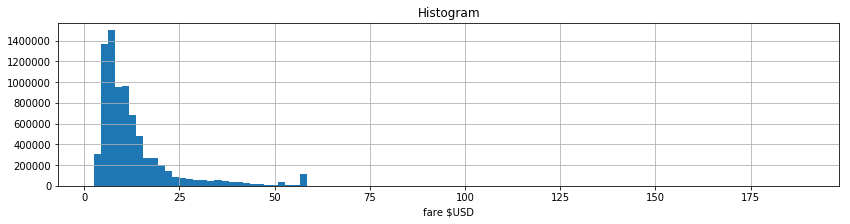

In [273]:
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

In [274]:
df.fare_amount.describe()

count    7.926829e+06
mean     1.268436e+01
std      1.015303e+01
min      2.510000e+00
25%      6.500000e+00
50%      9.500000e+00
75%      1.450000e+01
max      1.890000e+02
Name: fare_amount, dtype: float64

Text(0, 0.5, 'Fare')

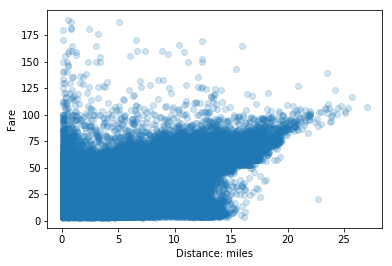

In [275]:
plt.scatter(df['distance'],df['fare_amount'],alpha=0.2)
plt.xlabel('Distance: miles')
plt.ylabel('Fare')

In [276]:
PickupCount = df.groupby(['pickup']).count()
DropoffCount = df.groupby(['dropoff']).count()

In [277]:
PickupCount['TripCount'] = PickupCount['fare_amount']
DropoffCount['TripCount'] = DropoffCount['fare_amount']
PickupCount['neighborhood'] = PickupCount.index
DropoffCount['neighborhood'] = DropoffCount.index
PickupCount = PickupCount[['TripCount','neighborhood']]
DropoffCount = DropoffCount[['TripCount','neighborhood']]

In [278]:
zones = gpd.read_file('D:\\dropbox\\Dropbox\\machine learning\\MLC_Project\\dataset\\neighborhoods.geojson')
zones = zones.merge(PickupCount, left_on='neighborhood', right_on='neighborhood')
zones = zones.merge(DropoffCount, left_on='neighborhood', right_on='neighborhood')
# zones

In [279]:
zones.rename(columns={'TripCount_x':'PickupAmount','TripCount_y':'DropoffAmount'},inplace=True)
zones = zones.to_crs({'init': 'epsg:2263'})

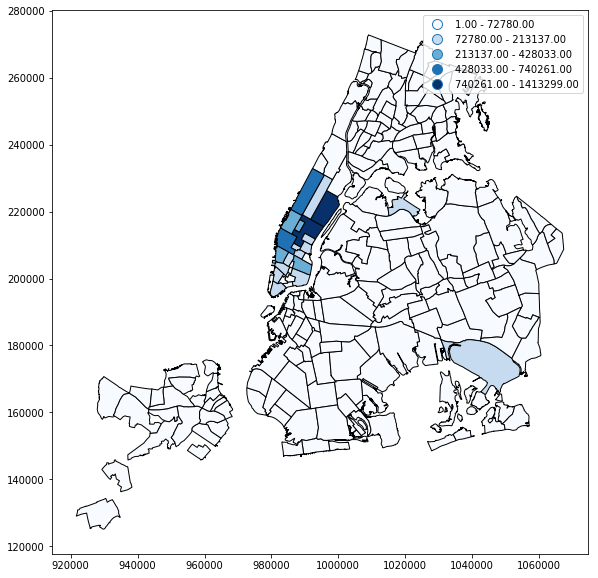

In [280]:
zones.plot(column='PickupAmount', cmap='Blues', figsize=(10,10), edgecolor='black', legend=True, scheme="fisher_Jenks")

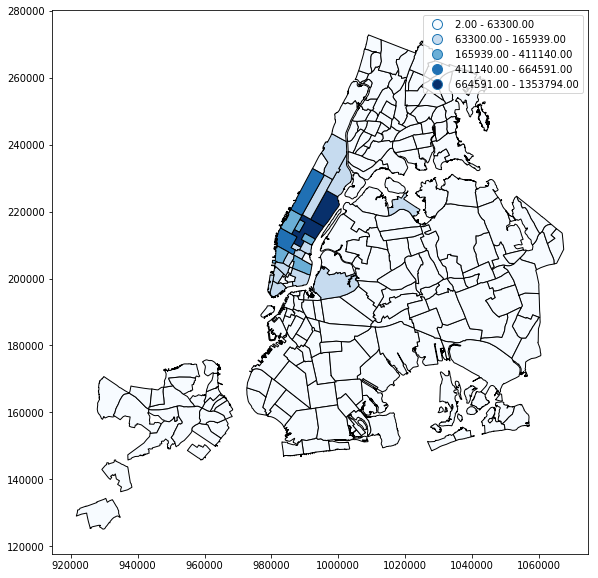

In [281]:
zones.plot(column='DropoffAmount', cmap='Blues', figsize=(10,10), edgecolor='black', legend=True, scheme="fisher_Jenks")

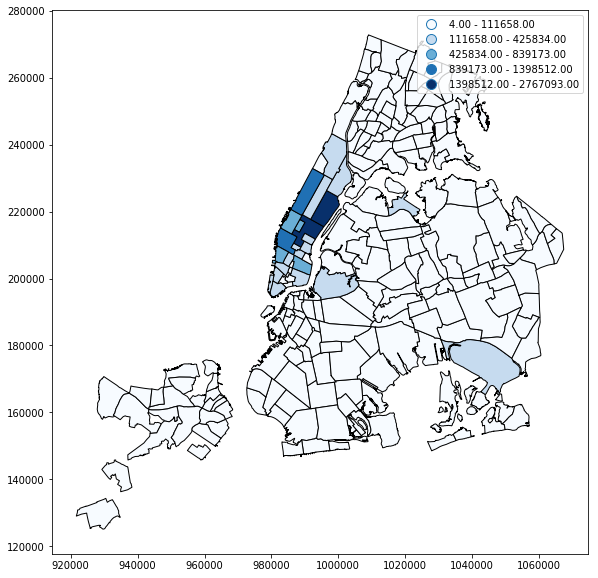

In [282]:
zones['TotalAmount'] = zones['PickupAmount']+zones['DropoffAmount']
zones.plot(column='TotalAmount', cmap='Blues', figsize=(10,10), edgecolor='black', legend=True, scheme="fisher_Jenks")

In [283]:
df['hour'] = df.apply(lambda x: x['datekey'].split('-')[-1],axis=1)
PickupNeighborCount = df.groupby(['datekey','pickup'],as_index=False).count()

In [284]:
PickupNeighborCount.head()

,datekey,pickup,fare_amount,weekend,distance,neighborhood,tripPerHour,holiday,dropoff,hour
0,2014-01-01-00,Astoria,11,11,11,11,11,11,11,11
1,2014-01-01-00,Battery Park City,6,6,6,6,6,6,6,6
2,2014-01-01-00,Bedford-Stuyvesant,5,5,5,5,5,5,5,5
3,2014-01-01-00,Boerum Hill,2,2,2,2,2,2,2,2
4,2014-01-01-00,Brooklyn Heights,8,8,8,8,8,8,8,8


In [285]:
PickupNeighborCount['MergeKey'] = PickupNeighborCount['datekey'].astype('str') + PickupNeighborCount['pickup'].astype('str')
PickupNeighborCount['PickupNeighborCount'] = PickupNeighborCount['fare_amount']
PickupNeighborCount = PickupNeighborCount[['MergeKey','fare_amount']]

In [286]:
df['MergeKey'] = df['datekey'].astype('str') + df['pickup'].astype('str')

In [287]:
PickupNeighborCount.rename(columns={'fare_amount':'PickupNeighborCount'},inplace=True)

In [288]:
df = df.merge(PickupNeighborCount,left_on='MergeKey',right_on='MergeKey')

In [289]:
df.head()

,fare_amount,weekend,distance,neighborhood,datekey,tripPerHour,holiday,pickup,dropoff,hour,MergeKey,PickupNeighborCount
0,12.5,0,1.619554,"('Theater District', 'Gramercy')",2014-02-19-07,1066,0,Theater District,Gramercy,07,2014-02-19-07Theater District,33
1,17.5,0,2.845245,"('Theater District', 'Tribeca')",2014-02-19-07,1066,0,Theater District,Tribeca,07,2014-02-19-07Theater District,33
2,5.0,0,0.412398,"('Theater District', 'Theater District')",2014-02-19-07,1066,0,Theater District,Theater District,07,2014-02-19-07Theater District,33
3,4.0,0,0.321753,"('Theater District', 'Theater District')",2014-02-19-07,1066,0,Theater District,Theater District,07,2014-02-19-07Theater District,33
4,8.5,0,1.180865,"('Theater District', 'Upper East Side')",2014-02-19-07,1066,0,Theater District,Upper East Side,07,2014-02-19-07Theater District,33


In [299]:
output = df[['fare_amount','weekend','distance','tripPerHour','holiday','PickupNeighborCount']]
output.to_csv('D:\\dropbox\\Dropbox\\machine learning\\MLC_Project\\dataset\\SevenFeatures.csv',index=False)

In [291]:
output.head()

,fare_amount,weekend,distance,tripPerHour,holiday,PickupNeighborCount
0,12.5,0,1.619554,1066,0,33
1,17.5,0,2.845245,1066,0,33
2,5.0,0,0.412398,1066,0,33
3,4.0,0,0.321753,1066,0,33
4,8.5,0,1.180865,1066,0,33


In [302]:
data = output[['fare_amount','weekend','holiday','tripPerHour','PickupNeighborCount','distance']]

In [306]:
output.columns

Index(['fare_amount', 'weekend', 'distance', 'tripPerHour', 'holiday',
       'PickupNeighborCount'],
      dtype='object')

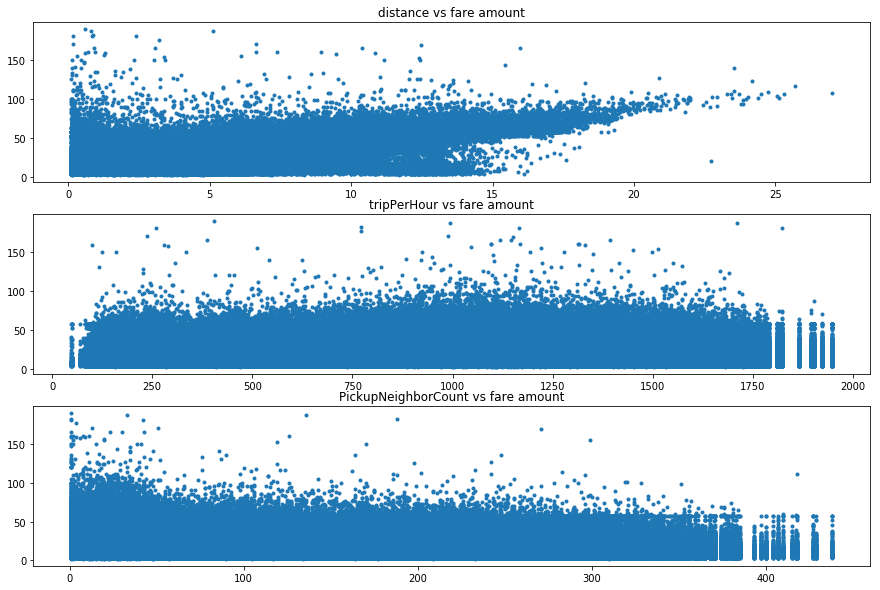

In [311]:
fig = plt.figure(figsize=(15,10))
for i,j in enumerate(['distance', 'tripPerHour','PickupNeighborCount']):
    ax = fig.add_subplot(3,1,i+1)
    ax.plot(data[j],data['fare_amount'],'.')
    ax.set_title('%s vs fare amount'%j)

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv('D:\\dropbox\\Dropbox\\machine learning\\MLC_Project\\dataset\\SevenFeatures.csv')
X = np.array(data[['weekend','holiday','tripPerHour','PickupNeighborCount','distance']])
y = np.array(data[['fare_amount']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
clf = linear_model.SGDRegressor(max_iter=10, tol=1e-3)
clf.fit(X_test, y_test)
y_pred = clf.predict(X_train)

C:\Users\brigh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\brigh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1229: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [13]:
MSE = ((y_pred - y_test)**2)/len(y_pred)

MemoryError: 